
# BIOMETRIA MIARFID 2021/2022

Ejercicio Eigenfaces & Fisherfaces

José Javier Calvo Moratilla

Se cargan las librerias necesárias

In [1]:
import os
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow 
import cv2 as cv2
!pip install opencv-contrib-python
from sklearn.decomposition import PCA


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Parámetros

In [2]:
caras = 40 #Caras totales
imgs = 5 #img por persona
pixeles = 10304 #10304 #píxeles x de una imagen
img_shape = (112, 92)

Se leen los datos de la carpeta local

In [3]:
from numpy.core.fromnumeric import size
input_folder = "drive/MyDrive/MUIARFID/BIOM/Practicas/identificacion/data/"

list_train = os.listdir(input_folder + 'Train')
list_test = os.listdir(input_folder + 'Test')


Comprobación de la lectura de las caras

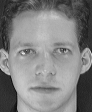

(112, 92, 3)


In [4]:
image = cv2.imread('drive/MyDrive/MUIARFID/BIOM/Practicas/identificacion/data/Train/s1/1.pgm')
cv2_imshow(image)
print(image.shape)

Generación de las matrices X_train, X_test, Y_train, Y_test

In [5]:
!ls "drive/MyDrive/MUIARFID/BIOM/Practicas/identificacion/data/Train/s1"
X_train = np.zeros(shape=(caras * imgs, pixeles))
Y_train = []

X_test = np.zeros(shape=(caras * imgs, pixeles))
Y_test = []

#Recorremos las imágenes y construimos la matriz X_train, Y_train
cnt = 0
for cara in tqdm(range(1, caras + 1)): # carpeta
  for im in range(1,imgs+1): # número archivo
    image = cv2.imread('drive/MyDrive/MUIARFID/BIOM/Practicas/identificacion/data/Train/s' + str(cara) + '/'+ str(im) + '.pgm', 0)
    X_train[cnt][:] = image.flatten()
    Y_train.append(int(cara))
    cnt +=1

#Recorremos las imágenes y construimos la matriz X_test, Y_test
cnt = 0
for cara in tqdm(range(1, caras + 1)): # carpeta
  for im in range(imgs + 1, 2 * imgs + 1): # número archivo
    image = cv2.imread('drive/MyDrive/MUIARFID/BIOM/Practicas/identificacion/data/Test/s' + str(cara) + '/'+ str(im) + '.pgm', 0)
    X_test[cnt][:] = image.flatten()
    Y_test.append(int(cara))
    cnt +=1

X_train = X_train.T
X_test = X_test.T
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print('\n\nX Train Shape: ',X_train.shape)
print('Y Train Shape: ',Y_train.shape)
#print('\n\nLabels: ', labels)

1.pgm  2.pgm  3.pgm  4.pgm  5.pgm


100%|██████████| 40/40 [00:46<00:00,  1.17s/it]



X Train Shape:  (10304, 200)
Y Train Shape:  (200,)


Se obtienen las medias de cada imagen


 Media train shape:  (10304,)


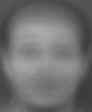

In [6]:
medias_train = X_train.mean(axis=1)
print('\n Media train shape: ', medias_train.shape)
cv2_imshow(medias_train.reshape(img_shape))

Se obtiene la matriz A

(10304, 200)


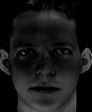

In [7]:
A_train = X_train.T - medias_train
A_train = A_train.T
print(A_train.shape)
cv2_imshow(A_train[:,0].reshape(img_shape))

Se obtiene la matrix de covariancias

In [8]:
#Matriz de covarianzas
img_totales = caras * imgs
#cov_matrix_train = (1/pixeles) * np.dot(A_train.T , A_train) # Píxeles = d
cov_matrix_train = np.cov(A_train.T)
print('Shape de la matrix de covarianzas = ', cov_matrix_train.shape)

Shape de la matrix de covarianzas =  (200, 200)


PCA



In [9]:
# B = Eigenvectors 
# Delta = Eigenvalues
def PCA(cov_matrix):
  # Se obtiene delta y b prima
  delta_prima, B_prima = np.linalg.eig(cov_matrix) 

  # se obtiene delta y B
  eigenVectors = np.dot(A_train, B_prima)
  eigenValues = np.dot((pixeles / (imgs * caras)),delta_prima)
  #print('Shape B = ', eigenVectors.shape)
  #print('Shape delta = ', eigenValues.shape)

  # Los eigenvectores así obtenidos son ortogonales pero no ortonormales. 
  # Hay que dividir cada vector por su módulo.
  modulos = np.linalg.norm(eigenVectors, axis=0)
  eigenVectors = eigenVectors / modulos

  # Se ordena B (EigenVectors)
  idx = delta_prima.argsort()[::-1] 
  eigenValues = delta_prima[idx]
  eigenVectors = eigenVectors[:, idx]
  #X_t = np.dot(eigenVectors[:,:dim].T, X_train)
  #X_te = np.dot(eigenVectors[:,:dim].T , X_test)

  return eigenVectors


KNN

In [10]:
from sklearn import neighbors

# Se prueba el modelo KNN con diferente reducción de dimensionalidad
# para así comprobar el efecto que produce en el rendimiento
dimensionalidad = list(range(1,200, 5))

res = {}

for d in dimensionalidad: 
  for k in range(1,6):  
    B = PCA(cov_matrix_train)
    X_train2 = np.dot(B[:,:d].T, X_train)
    X_test2 = np.dot(B[:,:d].T , X_test)
    clasificador = neighbors.KNeighborsClassifier(n_neighbors=k)
    clasificador.fit(X_train2.T, Y_train)
    res[str(k)+'NN_'+str(d)] = clasificador.score(X_test2.T, Y_test)
 

In [11]:
max_key = ''
max_value = 0.0

for this_value in res.items():
  key = this_value[0]
  value = this_value[1]
  
  if value > max_value:
    max_key = key
    max_value = value

print('El mejor resultado de KNN + PCA es: ', max_key, max_value)


El mejor resultado de KNN + PCA es:  1NN_41 0.89


Se obtiene la gráfica con los resultados para cada dimensión y KNN Vecinos más cercanos del 1 al 5

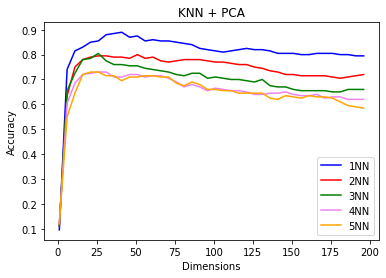

In [12]:
res_1 = [ v for k,v in res.items() if '1NN' in k]
res_2 = [ v for k,v in res.items() if '2NN' in k]
res_3 = [ v for k,v in res.items() if '3NN' in k]
res_4 = [ v for k,v in res.items() if '4NN' in k]
res_5 = [ v for k,v in res.items() if '5NN' in k]

plt.clf()
plt.plot(range(1,200, 5),  res_1, color='blue', label='1NN')
plt.plot(range(1,200, 5),  res_2, color='red', label='2NN')
plt.plot(range(1,200, 5),  res_3, color='green', label='3NN')
plt.plot(range(1,200, 5),  res_4, color='violet', label='4NN')
plt.plot(range(1,200, 5),  res_5, color='orange', label='5NN')
plt.xlabel('Dimensions')
plt.ylabel('Accuracy')
plt.title('KNN + PCA')
plt.legend()
plt.show()

Se realiza la pruba con PCA + LDA


In [13]:
import scipy.linalg as scipylg

def LDA(X, labels, dim):

    #print('El shape de X de entrada es: ', X.shape)

    mu = X.mean(axis = 1)
    #print('El shape de la media global es: ', mu.shape)
    sb = np.zeros((X.shape[0],X.shape[0]))
    sw = sb.copy()
    #print('El shape de sb y sw de entrada es: ', sb.shape)

    for label in set(labels):  

      # Se obtienen los índices de una clase concreta en los datos de X      
      indices = np.where(labels == label)   

      # Se obtiene la matriz correspondiente a los datos de una clase concreta  
      matriz_clase = X[:,indices[0]]

      # Se obtiene la media de clase de la matriz anterior
      mu_clase = matriz_clase.mean(axis = 1).reshape((X.shape[0],1))  

      # Se obtiene el número de muestras de la matriz      
      samples_class = matriz_clase.shape[1]

      # Se calculan sb y sw
      sb += samples_class * (mu_clase -mu)  * (mu_clase-mu).T
      sw += np.dot((matriz_clase-mu_clase) , (matriz_clase-mu_clase).T)
    
    # Se obtiene el valor C
    C = np.linalg.inv(sw) * sb  

    # Se obtienen los eigenValues, eigenVectors de la variable C  
    Delta, B = np.linalg.eig(C)

    # Se ordenan los eigenVectors de mayor a menor eigenValue
    idx = Delta.argsort()[::-1]    
    B = B[idx]

    # Se obtienen los datos con la reducción de dimensión aportada como parametro de la función LDA
    #res_X = np.dot(X.T, B[:,:dim])    

    #print('El shape de C es: ', C.shape)
    #print('El shape de Delta es: ', Delta.shape)
    #print('El shape de B es: ', B.shape)
    #print('El shape de res_X es: ', res_X.shape)
    
    return B

#X_t, X_te = PCA(cov_matrix_train, 4)
#X_lda = LDA(X_t, Y_train,2)
#print(B_lda_train.shape)


In [14]:
from sklearn import neighbors

mejor_dim = 41
# Se prueba el modelo KNN con diferente reducción de dimensionalidad
# para así comprobar el efecto que produce en el rendimiento
dimensionalidad = list(range(1,mejor_dim + 1, 1))

res = {}

B = PCA(cov_matrix_train)
X_train_pca = np.dot(B[:,:mejor_dim].T, X_train)
X_test_pca = np.dot(B[:,:mejor_dim].T , X_test)

for d in dimensionalidad: 
  for n in range(1,6): 

    B_lda = LDA(X_train_pca, Y_train, d)   

    X_train_lda = np.dot(B_lda[:,:d].T, X_train_pca) 
    X_test_lda = np.dot(B_lda[:,:d].T, X_test_pca) 

    clasificador = neighbors.KNeighborsClassifier(n_neighbors=n)
    clasificador.fit(X_train_lda.T, Y_train)
    res[str(n)+'NN_'+str(d)] = clasificador.score(X_test_lda.T, Y_test)

max_key = ''
max_value = 0.0

for this_value in res.items():
  key = this_value[0]
  value = this_value[1]
  
  if value > max_value:
    max_key = key
    max_value = value

print('El mejor resultado de KNN + PCA + LDA es: ', max_key, max_value)

El mejor resultado de KNN + PCA + LDA es:  1NN_41 0.89


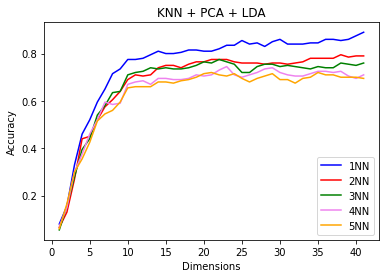

In [15]:
res_1 = [ v for k,v in res.items() if '1NN' in k]
res_2 = [ v for k,v in res.items() if '2NN' in k]
res_3 = [ v for k,v in res.items() if '3NN' in k]
res_4 = [ v for k,v in res.items() if '4NN' in k]
res_5 = [ v for k,v in res.items() if '5NN' in k]

plt.clf()
plt.plot(range(1,mejor_dim + 1, 1),  res_1, color='blue', label='1NN')
plt.plot(range(1,mejor_dim + 1, 1),  res_2, color='red', label='2NN')
plt.plot(range(1,mejor_dim + 1, 1),  res_3, color='green', label='3NN')
plt.plot(range(1,mejor_dim + 1, 1),  res_4, color='violet', label='4NN')
plt.plot(range(1,mejor_dim + 1, 1),  res_5, color='orange', label='5NN')
plt.xlabel('Dimensions')
plt.ylabel('Accuracy')
plt.title('KNN + PCA + LDA')
plt.legend()
plt.show()